In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("..")

import numpy as np
import torch
import random
from tqdm import tqdm

import matplotlib.pyplot as plt

from src.datasets import data, utils, configs
from src.datasets.utils import dump_generated_dataset, PreGeneratedDataset
from src.models import base_models, slot_attention
import os
from src import metrics

from torchvision import transforms as transforms

seed = 43
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

from utils.decoder_evaluation import calculate_decoder_optimality, get_left_right_datasets, scale, min_offset
from utils.heatmap_utils import *

In [61]:
path = "D:/mnt/qb/work/bethge/apanfilov27/object_centric_consistency_project/dsprites/test/no_overlap_off_diagonal/2_objects"
ood_dataset = PreGeneratedDataset(path, 5000)

path = "D:/mnt/qb/work/bethge/apanfilov27/object_centric_consistency_project/dsprites/test/diagonal/2_objects"
id_dataset = PreGeneratedDataset(path, 5000)

In [128]:
def load_model_and_hook(path, model_name):
    # Load the checkpoint
    checkpoint = torch.load(path)
    
    # Determine which model to load based on the model name
    if model_name == "SlotAttention":
        encoder = slot_attention.SlotAttentionEncoder(
            resolution=(64, 64),
            hid_dim=16,
            ch_dim=32,
            dataset_name="dsprites",
        )
        decoder = slot_attention.SlotAttentionDecoder(
            hid_dim=16,
            ch_dim=32,
            resolution=(64, 64),
            dataset_name="dsprites",
        )
        model = slot_attention.SlotAttentionAutoEncoder(
            encoder=encoder,
            decoder=decoder,
            num_slots=2,
            num_iterations=3,
            hid_dim=16,
            dataset_name="dsprites",
        )
        decoder_hook = model.decode
    elif model_name == "SlotMLPAdditive":
        model = base_models.SlotMLPAdditive(3, 2, 16)
        decoder_hook = model.decoder
    else:
        raise ValueError("Invalid model name")
    
    # Load the model weights and set the model to eval model
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    return model, decoder_hook


def evaluate_function_over_seeds(func, seeds, *args, **kwargs):
    results = {"mse_model": [], "mse_decoder": [], "figures_mse_model": []}
    
    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        temp_results = func(*args, **kwargs)
        
        # If results lists are empty, initialize them with lists for each sample
        if not results["mse_model"]:
            results["mse_model"] = [[] for _ in range(len(temp_results["model_performances"]))]
            results["mse_decoder"] = [[] for _ in range(len(temp_results["model_performances"]))]
            results["figures_mse_model"] = [[] for _ in range(len(temp_results["model_performances"]))]
        
        for i in range(len(temp_results["model_performances"])):
            results["mse_model"][i].append(temp_results["model_performances"][i]["mse_model"])
            results["mse_decoder"][i].append(temp_results["model_performances"][i]["mse_decoder"])
            results["figures_mse_model"][i].append(temp_results["model_performances"][i]["figures_mse_model"])
    
    # Compute median for each sample
    for key in results:
        results[key] = [np.median(torch.stack(results[key][i]), axis=0) for i in range(len(results[key]))]
    
    # re-arrange the results
    out = []
    for i in range(len(results["mse_model"])):
        out.append(dict())
        for key in results:
            out[i][key] = results[key][i]
    
    return out

def cast_models_to_device(device, models):
    for model in models:
        model.cuda()

In [4]:
diagonal_dataset_left, diagonal_dataset_right = get_left_right_datasets(ood_dataset)

Generating images (sampling: skip): 100%|█████████████████████████████████████████| 5000/5000 [00:42<00:00, 117.07it/s]


In [4]:
paths = "D:/git_projects/bethgelab/lab_rotation/object_centric_ood/notebooks/models/SlotMLPAdditive_2obj_300_vanilla_no_overlaps"
paths_and_names = [
    (os.path.join(paths, "SlotMLPAdditive_2obj_300_vanilla_no_overlaps_2023.pt"), "SlotMLPAdditive"),
    (os.path.join(paths, "SlotMLPAdditive_2obj_300_vanilla_no_overlaps_2024.pt"), "SlotMLPAdditive"),
    (os.path.join(paths, "SlotMLPAdditive_2obj_300_vanilla_no_overlaps_2027.pt"), "SlotMLPAdditive"),
    (os.path.join(paths, "SlotMLPAdditive_2obj_300_vanilla_no_overlaps_2028.pt"), "SlotMLPAdditive"),
    (os.path.join(paths, "SlotMLPAdditive_2obj_300_vanilla_no_overlaps_2031.pt"), "SlotMLPAdditive"),
]

models = []
hooks = []
for (path, name) in paths_and_names:
    model, decoder_hook= load_model_and_hook(path, name)
    models.append(model)
    hooks.append(decoder_hook)

cast_models_to_device("cuda")    

    
SlotMLPAdditive_output = calculate_decoder_optimality(ood_dataset, 
                                                      diagonal_dataset_left, 
                                                      diagonal_dataset_right, 
                                                      models, hooks, device="cuda", output_figures=True)
seeds = [43, 44, 45, 46]
SlotMLPAdditive_output = evaluate_function_over_seeds(calculate_decoder_optimality, 
                                                         seeds, ood_dataset, 
                                                         diagonal_dataset_left, diagonal_dataset_right, 
                                                         models, hooks, device="cuda")

NameError: name 'ood_dataset' is not defined

In [13]:
paths = "D:/git_projects/bethgelab/lab_rotation/object_centric_ood/notebooks/models/SlotAttention_2obj_400_vanilla_no_overlaps"
paths_and_names = [
    (os.path.join(paths, "SlotAttention_2obj_400_vanilla_no_overlaps_2023.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_400_vanilla_no_overlaps_2024.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_400_vanilla_no_overlaps_2025.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_400_vanilla_no_overlaps_2026.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_400_vanilla_no_overlaps_2027.pt"), "SlotAttention"),
]
models = []
hooks = []
for (path, name) in paths_and_names:
    model, decoder_hook= load_model_and_hook(path, name)
    models.append(model)
    hooks.append(decoder_hook)

cast_models_to_device("cuda")    

SlotAttention_out = calculate_decoder_optimality(ood_dataset, 
                                                      diagonal_dataset_left, 
                                                      diagonal_dataset_right, 
                                                      models, hooks, device="cuda", output_figures=True)

# seeds = [43, 44, 45, 46]
# SlotAttention_out = evaluate_function_over_seeds(calculate_decoder_optimality, 
#                                                          seeds, traversed_dataset, 
#                                                          diagonal_dataset_left, diagonal_dataset_right, 
#                                                          models, hooks, device="cuda")

NameError: name 'ood_dataset' is not defined

In [12]:
paths = "D:/git_projects/bethgelab/lab_rotation/object_centric_ood/notebooks/models/SlotAttention_2obj_vanilla_nooverlaps_nomasks"
paths_and_names = [
    (os.path.join(paths, "SlotAttention_2obj_nooverlaps_nomasks_vanilla_400_2089.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_nooverlaps_nomasks_vanilla_400_2088.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_nooverlaps_nomasks_vanilla_400_2081.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_nooverlaps_nomasks_vanilla_400_2075.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_nooverlaps_nomasks_vanilla_400_2073.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_nooverlaps_nomasks_vanilla_400_2038.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_nooverlaps_nomasks_vanilla_400_2026.pt"), "SlotAttention"),
]

models = []
hooks = []
for (path, name) in paths_and_names:
    model, decoder_hook= load_model_and_hook(path, name)
    models.append(model)
    hooks.append(decoder_hook)

cast_models_to_device("cuda")    

SlotAttention_out_nomasks = calculate_decoder_optimality(ood_dataset, 
                                                      diagonal_dataset_left, 
                                                      diagonal_dataset_right, 
                                                      models, hooks, device="cuda", output_figures=True)
# seeds = [43, 44, 45, 46]
# SlotAttention_out_nomasks = evaluate_function_over_seeds(calculate_decoder_optimality, 
#                                                          seeds, ood_dataset, 
#                                                          diagonal_dataset_left, diagonal_dataset_right, 
#                                                          models, hooks, device="cuda")

7it [04:16, 36.69s/it]


In [ ]:
paths = "D:/git_projects/bethgelab/lab_rotation/object_centric_ood/notebooks/models/SlotAttention_2obj_enccons_nooverlaps_nomasks"
paths_and_names = [
    (os.path.join(paths, "SlotAttention_2obj_nooverlaps_nomasks_enccons_400_2026.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_nooverlaps_nomasks_enccons_400_2038.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_nooverlaps_nomasks_enccons_400_2073.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_nooverlaps_nomasks_enccons_400_2075.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_nooverlaps_nomasks_enccons_400_2081.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_nooverlaps_nomasks_enccons_400_2088.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_nooverlaps_nomasks_enccons_400_2089.pt"), "SlotAttention"),
]

models = []
hooks = []
for (path, name) in paths_and_names:
    model, decoder_hook= load_model_and_hook(path, name)
    models.append(model)
    hooks.append(decoder_hook)

cast_models_to_device("cuda")    

# SlotAttention_out_nomasks_enccons = calculate_decoder_optimality(ood_dataset, 
#                                                       diagonal_dataset_left, 
#                                                       diagonal_dataset_right, 
#                                                       models, hooks, device="cuda", output_figures=True)

seeds = [43, 44, 45, 46]
SlotAttention_out_nomasks_enccons = evaluate_function_over_seeds(calculate_decoder_optimality, 
                                                         seeds, ood_dataset, 
                                                         diagonal_dataset_left, diagonal_dataset_right, 
                                                         models, hooks, device="cuda")

7it [03:53, 33.41s/it]
7it [04:27, 38.17s/it]
7it [04:37, 39.59s/it]
6it [03:57, 39.52s/it]

In [5]:
paths = "D:/git_projects/bethgelab/lab_rotation/object_centric_ood/notebooks/models/SlotAttention_2obj_400_enccons_no_overlaps"
paths_and_names = [
    (os.path.join(paths, "SlotAttention_2obj_400_enccons_no_overlaps_2023.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_400_enccons_no_overlaps_2024.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_400_enccons_no_overlaps_2025.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_400_enccons_no_overlaps_2026.pt"), "SlotAttention"),
    (os.path.join(paths, "SlotAttention_2obj_400_enccons_no_overlaps_2027.pt"), "SlotAttention"),
]

models = []
hooks = []
for (path, name) in paths_and_names:
    model, decoder_hook= load_model_and_hook(path, name)
    models.append(model)
    hooks.append(decoder_hook)

cast_models_to_device("cuda")    

SlotAttention_out_enccons = calculate_decoder_optimality(ood_dataset, 
                                                      diagonal_dataset_left, 
                                                      diagonal_dataset_right, 
                                                      models, hooks, device="cuda", output_figures=True)

5it [02:52, 34.51s/it]


In [6]:
ood_figures = torch.zeros((5000, 3, 64, 64))

In [7]:
for i, batch in enumerate(ood_dataset):
    ood_figures[i] = batch[0][-1]

In [29]:
# def calculate_mse(performances, ood_figures):
#     output = []
#     for i in range(len(performances)):
#         output.append(metrics.reconstruction_loss(performances[i], ood_figures))
#     output = np.array(output)
#     return output.mean(), output.std()

def calculate_mse(performances, key, clip=0.999):
    accum_mse = 0
    for i in range(len(performances)):
        accum_mse += np.clip(performances[i][key], 0, np.quantile(performances[i][key], clip))
    
    return accum_mse / len(performances)

def calculate_r2(performances, ood_figures):
    output = []
    for i in range(len(performances)):
        output.append(metrics.image_r2_score(performances[i], ood_figures))
    output = np.array(output)
    return output.mean(), output.std()

In [21]:
print("MODEL")
print(calculate_r2(SlotMLPAdditive_output["reconstructed_images"], ood_figures))

print("DECODER")
print(calculate_r2(SlotMLPAdditive_output["ood_matched_figures"], ood_figures))

MODEL
(0.71509784, 0.0150996195)
DECODER
(0.99733293, 0.0004630557)


In [33]:
calculate_mse(SlotMLPAdditive_output, "mse_model", clip=1.0).mean()

32.473213

In [18]:
print("MODEL")
print(calculate_r2(SlotAttention_out["reconstructed_images"], ood_figures))

print("DECODER")
print(calculate_r2(SlotAttention_out["ood_matched_figures"], ood_figures))

MODEL
(0.7405845, 0.0675093)
DECODER
(0.94105494, 0.067634396)


In [16]:
print("MODEL")
print(calculate_r2(SlotAttention_out_enccons["reconstructed_images"], ood_figures))

print("DECODER")
print(calculate_r2(SlotAttention_out_enccons["ood_matched_figures"], ood_figures))

MODEL
(0.80269593, 0.008756061)
DECODER
(0.99823606, 0.0005273508)


In [14]:
print("MODEL")
print(calculate_r2(SlotAttention_out_nomasks["reconstructed_images"], ood_figures))

print("DECODER")
print(calculate_r2(SlotAttention_out_nomasks["ood_matched_figures"], ood_figures))

MODEL
(0.8097561, 0.015541609)
DECODER
(0.9988093, 0.00041683792)


In [15]:
print("MODEL")
print(calculate_r2(SlotAttention_out_nomasks_enccons["reconstructed_images"], ood_figures))

print("DECODER")
print(calculate_r2(SlotAttention_out_nomasks_enccons["ood_matched_figures"], ood_figures))

MODEL
(0.86806434, 0.046603654)
DECODER
(0.99840343, 0.00057590764)


In [22]:
print("MSE MODEL")
print(calculate_mse(SlotAttention_out_nomasks_enccons["reconstructed_images"], ood_figures))

print("MSE DECODER")
print(calculate_mse(SlotAttention_out_nomasks_enccons["ood_matched_figures"], ood_figures))

MSE MODEL
(17.089613, 6.129813)
MSE DECODER
(0.20648721, 0.07448875)


In [37]:
calculate_mse(SlotAttention_out_nomasks_enccons["model_performances"], "mse_model", clip=1.0).mean()

tensor(17.0896)

In [ ]:
calculate_mse(SlotAttention_out_nomasks_enccons, "mse_model", clip=1.0).mean()

In [1]:
import numpy as np

In [2]:
np.array((2039, 2037, 2027, 2028, 2024)) - 2023

array([16, 14,  4,  5,  1])

In [1]:
np.array((2060, 2057, 2044, 2056, 2031, 2029, 2024, 2035)) - 2023

NameError: name 'np' is not defined

In [62]:
ood_loader = torch.utils.data.DataLoader(
            ood_dataset,
            batch_size=64,
            shuffle=False,
            collate_fn=lambda b: utils.collate_fn_normalizer(b, min_offset, scale),
        )


id_loader = torch.utils.data.DataLoader(
            id_dataset,
            batch_size=64,
            shuffle=False,
            collate_fn=lambda b: utils.collate_fn_normalizer(b, min_offset, scale),
        )

In [129]:
paths = "D:/git_projects/bethgelab/lab_rotation/object_centric_ood/notebooks/models/SlotAttention_2obj_nooverlaps_nomasks_nosampling_vanilla_600"
paths_and_names = []
for name in os.listdir(paths):
    if name.endswith(".pt"):
        paths_and_names.append((os.path.join(paths, name), "SlotAttention"))


vanilla_models = []
vanilla_hooks = []
for (path, name) in paths_and_names:
    model, decoder_hook= load_model_and_hook(path, name)
    vanilla_models.append(model)
    vanilla_hooks.append(decoder_hook)

cast_models_to_device("cuda", vanilla_models)

paths = "D:/git_projects/bethgelab/lab_rotation/object_centric_ood/notebooks/models/SlotAttention_2obj_nooverlaps_nomasks_nosampling_enccons_600"
paths_and_names = []
for name in os.listdir(paths):
    if name.endswith(".pt"):
        paths_and_names.append((os.path.join(paths, name), "SlotAttention"))
        
enccons_models = []
enccons_hooks = []
for (path, name) in paths_and_names:
    model, decoder_hook= load_model_and_hook(path, name)
    enccons_models.append(model)
    enccons_hooks.append(decoder_hook)

cast_models_to_device("cuda", enccons_models)

In [8]:
from tqdm import tqdm

In [130]:
def eval_loader(loader, models):
    output_array = []
    for model in models:
        model_mse = []
        y_coords = []
        c_coords = []
        with torch.no_grad():
            for (image, latent) in tqdm(loader):
                image = image[:, -1, ...].to("cuda")
                out = model(image)

                y_coord = latent[:, 0, 1] - latent[:, 1, 1]
                c_coord = latent[:, 0, -1] - latent[:, 1, -1]
                loss = (image - out["reconstructed_image"]).square().cpu().reshape(image.shape[0], -1).sum(dim=1)

                c_coords.append(c_coord)
                y_coords.append(y_coord)
                model_mse.append(loss)

            output_array.append((np.concatenate(y_coords), np.concatenate(c_coords), np.concatenate(np.array(model_mse))))
    return output_array

In [131]:
vanilla_ood_out = eval_loader(ood_loader, vanilla_models)
vanilla_id_out = eval_loader(id_loader, vanilla_models)

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:34<00:00,  2.29it/s]
C:\Users\sasha\AppData\Local\Temp\ipykernel_21476\1469420619.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  output_array.append((np.concatenate(y_coords), np.concatenate(c_coords), np.concatenate(np.array(model_mse))))
C:\Users\sasha\AppData\Local\Temp\ipykernel_21476\1469420619.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depreca

In [144]:
enccons_ood_out = eval_loader(ood_loader, enccons_models)
enccons_id_out = eval_loader(id_loader, enccons_models)

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.35it/s]
C:\Users\sasha\AppData\Local\Temp\ipykernel_21476\1469420619.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  output_array.append((np.concatenate(y_coords), np.concatenate(c_coords), np.concatenate(np.array(model_mse))))
C:\Users\sasha\AppData\Local\Temp\ipykernel_21476\1469420619.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depreca

In [19]:
y_coord.shape

torch.Size([5])

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# def plot_heatmap(data_sets, cmap='icefire', interpolation_method='nearest'):
#     # Concatenate all x, y, and loss values
#     x = np.concatenate([t[0] for t in data_sets])
#     y = np.concatenate([t[1] for t in data_sets])
#     loss = np.concatenate([t[2] for t in data_sets])

#     # Create a grid
#     xi, yi = np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100)
#     xi, yi = np.meshgrid(xi, yi)

#     # Interpolate the loss values to fit the grid
#     zi = griddata((x, y), loss, (xi, yi), method=interpolation_method)

#     # Create the heatmap with vmin set to 0
#     plt.imshow(zi, extent=[min(x), max(x), min(y), max(y)], origin='lower', cmap=cmap, vmin=0)
    
    
#         # Plot the original points for each set
#     colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']
#     for i, (xi, yi, _) in enumerate(data_sets):
#         plt.scatter(xi, yi, c=colors[i % len(colors)], label=f'Set {i + 1}', s=0.1)

#     plt.colorbar(label='Loss')
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.title('Combined Heatmap')
#     plt.show()



In [168]:
def plot_heatmap(data_sets, max_value, cmap='viridis', num_bins=50, title="Empty"):
    # Initialize lists to store x, y, and loss values
    x_all = []
    y_all = []
    loss_all = []

    # Iterate over the data sets
    for x, y, loss, exclude_region in data_sets:
        # Exclude points where abs(x - y) <= 0.125 if exclude_region is True
        if exclude_region:
            mask = np.abs(x - y) > 0.125
            x = x[mask]
            y = y[mask]
            loss = loss[mask]

        x_all.append(x)
        y_all.append(y)
        loss_all.append(loss)

    # Concatenate all x, y, and loss values
    x = np.concatenate(x_all)
    y = np.concatenate(y_all)
    loss = np.concatenate(loss_all)

    # Normalize the loss by the provided maximal value
    loss = loss / max_value

    # Define the bins for the x and y axes
    x_bins = np.linspace(min(x), max(x), num_bins)
    y_bins = np.linspace(min(y), max(y), num_bins)

    # Create a grid of mean loss values for each bin
    mean_loss_grid = np.zeros((num_bins - 1, num_bins - 1))
    for i in range(num_bins - 1):
        for j in range(num_bins - 1):
            in_bin = (x >= x_bins[i]) & (x < x_bins[i + 1]) & (y >= y_bins[j]) & (y < y_bins[j + 1])
            mean_loss_grid[j, i] = np.mean(loss[in_bin]) if np.any(in_bin) else np.nan

    # Create the heatmap
    plt.imshow(mean_loss_grid, origin='lower', cmap=cmap, vmin=0, vmax=1, aspect='equal')

    # Remove ticks and axis labels
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

    plt.colorbar(label='Loss')
    plt.title(title)
    plt.show()


In [169]:
np.array(vanilla_ood_out).mean(axis=0)[-1]

array([248.86255   ,  39.578682  ,   6.7561874 , ...,   2.0676367 ,
         0.37795907,   0.6334674 ], dtype=float32)

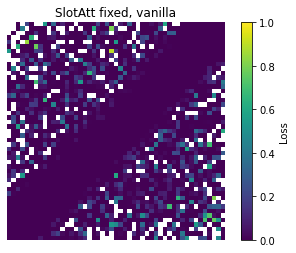

In [170]:
plot_heatmap([
    (
        id_dataset.latents[:, 0, -1], id_dataset.latents[:, 1, -1], np.array(vanilla_id_out).mean(axis=0)[-1], False
    ),
    (
        ood_dataset.latents[:, 0, -1], ood_dataset.latents[:, 1, -1], np.array(vanilla_ood_out).mean(axis=0)[-1], True
    )
             ], 
    np.array(vanilla_ood_out).mean(axis=0).max(),
    title="SlotAtt fixed, vanilla"
)

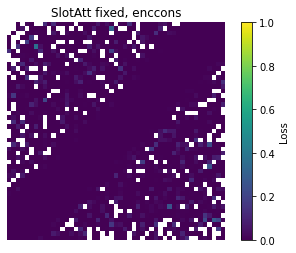

In [171]:
plot_heatmap([
    (
        id_dataset.latents[:, 0, -1], id_dataset.latents[:, 1, -1], np.array(enccons_id_out).mean(axis=0)[-1], False
    ),
    (
        ood_dataset.latents[:, 0, -1], ood_dataset.latents[:, 1, -1], np.array(enccons_ood_out).mean(axis=0)[-1], True
    )
             ], np.array(vanilla_ood_out).mean(axis=0).max(),
        title="SlotAtt fixed, enccons"

)